In [1]:
# model orbits with python and jupyter widgets

In [19]:
# -*- coding: utf-8 -*-
import numpy as np
import scipy as sp
from pylab import *
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
from scipy.integrate import odeint

In [20]:
def convert_r_v(r, v): # converts position and velocity vectors, r and v, into orbital elements
    unit_i = np.array([1, 0, 0])
    unit_j = np.array([0, 1, 0])
    unit_k = np.array([0, 0, 1])
    mag_r = np.linalg.norm(r)
    mag_v = np.linalg.norm(v)
    mu = 1
    h = np.cross(r, v)
    n = np.cross(unit_k, h)
    mag_n = np.linalg.norm(n)
    mag_h = np.linalg.norm(h)
    p = mag_h**2
    e = (1 / mu) * ((r * (mag_v**2 - (mu / mag_r))) - (v * np.dot(r, v)))
    mag_e = np.linalg.norm(e)
    i = np.arccos((np.dot(h, unit_k)) / mag_h)
    if mag_n == 0:
        little_omega = 'none'
        big_omega = 'none'
    else:
        little_omega = np.arccos(np.dot(n, e) / (mag_n * mag_e))
        big_omega = np.arccos(np.dot(n, unit_i) / mag_n)
    nu = np.arccos(np.dot(e, r) / (mag_e * mag_r))
    return (p, mag_e, i, little_omega, big_omega, nu)

def convert_orbital_perifocal(p, e, nu): # converts orbital elements into position and velocity vectors in the perifocal frame
    mu = 1
    mag_r = p / (1 + (e * np.cos(nu)))
    r = np.array([mag_r * np.cos(nu), mag_r * np.sin(nu), 0])
    v = np.array([((mu / p) ** (1 / 2)) * (-1 * np.sin(nu)), ((mu / p) ** (1 / 2)) * (e + np.cos(nu)), 0])
    return r, v

def convert_orbital_geocentric(p, e, i, little_omega, big_omega, nu): # converts orbital elements into perifocal then geocentric
    r, v = convert_orbital_perifocal(p, e, nu)
    if big_omega == 'none' or little_omega == 'none':
        return r, v
    else:
        trans_matrix = np.array([[(np.cos(big_omega) * np.cos(little_omega)) - (np.sin(big_omega) * np.sin(little_omega) * np.cos(i)),
                                  (-1 * np.cos(big_omega) * np.sin(little_omega)) - (np.sin(big_omega) * np.cos(little_omega) * np.cos(i)),
                                  np.sin(big_omega) * np.sin(i)],
                                 [(np.sin(big_omega) * np.cos(little_omega)) + (np.cos(big_omega) * np.sin(little_omega) * np.cos(i)),
                                  (-1 * np.sin(big_omega) * np.sin(little_omega)) + (np.cos(big_omega) * np.cos(little_omega) * np.cos(i)),
                                  -1 * np.cos(big_omega) * np.sin(i)],
                                 [np.sin(little_omega) * np.sin(i), np.cos(little_omega) * np.sin(i), np.cos(i)]])
        r = np.dot(r, np.transpose(trans_matrix))
        v = np.dot(v, np.transpose(trans_matrix))
        x = np.array([r[0],r[1],r[2],v[0],v[1],v[2]])
        return x

In [21]:
# G = 6.67408 * 10**(-11)
# M = 5.972 * 10**24
GM = 3.986004418*(10**14)
def TwoBody(state, t):
    #unpack state vector
    x = state[0]
    y = state[1]
    z = state[2]
    r = (x**2 + y**2 + z**2)**(1/2)
#     print(r)
    
    xd = state[3]
    yd = state[4]
    zd = state[5]
    xdd = -((GM)/(r**3)) * x
    ydd = -((GM)/(r**3)) * y
    zdd = -((GM)/(r**3)) * z
    
#     print([xd, yd, zd, xdd, ydd, zdd])
    return [xd, yd, zd, xdd, ydd, zdd]

In [27]:
def plot_oe(p, e, i, little_omega, big_omega, nu): # converts orbital elements into perifocal then geocentric
    r, v = convert_orbital_perifocal(p, e, nu)
    if big_omega == 'none' or little_omega == 'none':
        pass
    else:
        trans_matrix = np.array([[(np.cos(big_omega) * np.cos(little_omega)) - (np.sin(big_omega) * np.sin(little_omega) * np.cos(i)),
                                  (-1 * np.cos(big_omega) * np.sin(little_omega)) - (np.sin(big_omega) * np.cos(little_omega) * np.cos(i)),
                                  np.sin(big_omega) * np.sin(i)],
                                 [(np.sin(big_omega) * np.cos(little_omega)) + (np.cos(big_omega) * np.sin(little_omega) * np.cos(i)),
                                  (-1 * np.sin(big_omega) * np.sin(little_omega)) + (np.cos(big_omega) * np.cos(little_omega) * np.cos(i)),
                                  -1 * np.cos(big_omega) * np.sin(i)],
                                 [np.sin(little_omega) * np.sin(i), np.cos(little_omega) * np.sin(i), np.cos(i)]])
        r = np.dot(r, np.transpose(trans_matrix))
        v = np.dot(v, np.transpose(trans_matrix))
#         x = np.array([r[0],r[1],r[2],v[0],v[1],v[2]])
    
    x0 = r[0] * 6378145
    y0 = r[1] * 6378145
    z0 = r[2] * 6378145
    u0 = v[0] * 7905.36828
    v0 = v[1] * 7905.36828
    w0 = v[2] * 7905.36828
    state0 = [x0, y0, z0, u0, v0, w0]
    print('STATE0', state0)
    t = arange(0.0, 60*60*4)

    state = odeint(TwoBody, state0, t)
    X = [s[0]/1e3 for s in state]
    Y = [s[1]/1e3 for s in state]
    Z = [s[2]/1e3 for s in state]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(X, Y, Z)    

STATE0 [282466.22332371795, -2690092.9581338838, 352199.06033969927, -9070.617758432636, -303.13965709281712, 9604.93338226573]


<IPython.core.display.Javascript object>


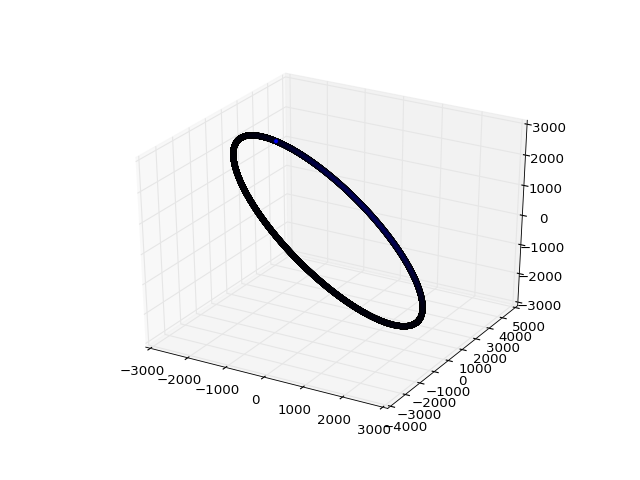

In [28]:
f = interact(plot_oe, p = (0.01, 2), e = (0.0, 1.0), i = (0, 359), little_omega = (0, 359), big_omega = (0, 359), nu = (0, 359))